#  Work with Unbalanced Data to predict Stroke

**Summary**


In this notebook I'm going to investigate all technics that are useful for Unbalanced Data. I took most of information [here](https://imbalanced-learn.org/stable/index.html), in wonderful module Imbalanced-Learn

![](https://imbalanced-learn.org/stable/_static/logo_wide.png)

# Preparation

In [218]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#models
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import RUSBoostClassifier
from sklearn.svm import SVC

# DATA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector as selector
from  imblearn.over_sampling import RandomOverSampler, SMOTENC, SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn import FunctionSampler


from imblearn.pipeline import make_pipeline # the number of samples can vary during training
from imblearn.under_sampling import RandomUnderSampler


#metrics
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, confusion_matrix, roc_auc_score, recall_score
from imblearn.metrics import classification_report_imbalanced

import warnings
warnings.filterwarnings("ignore")

In [219]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [220]:
path = '/content/drive/MyDrive/Data/healthcare-dataset-stroke-data.csv'

data = pd.read_csv(path)

In [221]:
data.shape

(5110, 12)

# Work with Data

* Delete one row where gender = "Other",
* Delete "id" column since it doesn't give an information

In [222]:
data.drop(data[data['gender']=='Other'].index,inplace=True)
data = data.drop('id', axis=1)

In [223]:
data.loc[data['stroke'] == 1].sort_values(by='age')

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
245,Female,14.00,0,0,No,children,Rural,57.93,30.9,Unknown,1
182,Female,32.00,0,0,Yes,Private,Rural,76.13,29.9,smokes,1
118,Female,38.00,0,0,No,Self-employed,Urban,82.28,24.0,formerly smoked,1
133,Female,38.00,0,0,Yes,Private,Rural,101.45,NaN,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
42,Male,82.00,0,1,Yes,Private,Urban,144.90,26.4,smokes,1
56,Female,82.00,0,0,Yes,Private,Rural,59.32,33.2,never smoked,1
188,Male,82.00,0,0,Yes,Private,Rural,86.62,29.5,formerly smoked,1
23,Male,82.00,0,1,Yes,Private,Rural,208.30,32.5,Unknown,1


* There are 3 persons who are 1 and 14 and 32 years old and nothing in Data point directly to cause of their stroke.
* I consider them as outliers.

In [224]:
data = data.drop(labels=[162, 245, 182], axis=0)

Also, the first stroke was in age 38, let's find out how many persons, younger than 38, datset contains

In [225]:
children = data.loc[data['age'] < 38]
print(f'There are {children.shape[0]} !!!! young persons in Dataset and all of them does not have a stroke')
persent = round((children.shape[0]*100/data.shape[0]), 2)
print(f'This is {persent} % of whole Dataset')

There are 2023 !!!! young persons in Dataset and all of them does not have a stroke
This is 39.62 % of whole Dataset


 * There is some technique called "Under-sampling" which we can not afford this time since out Dataset has not enough data to perform it.
 * But in this case it's worth to get rid of half of 'children' data since it's not super informative.

In [226]:
import random
a = np.array(children.index)
del_i = pd.Series(np.random.choice(a, size=700))
data = data.drop(del_i)


Take a look to some graphs

<Axes: >

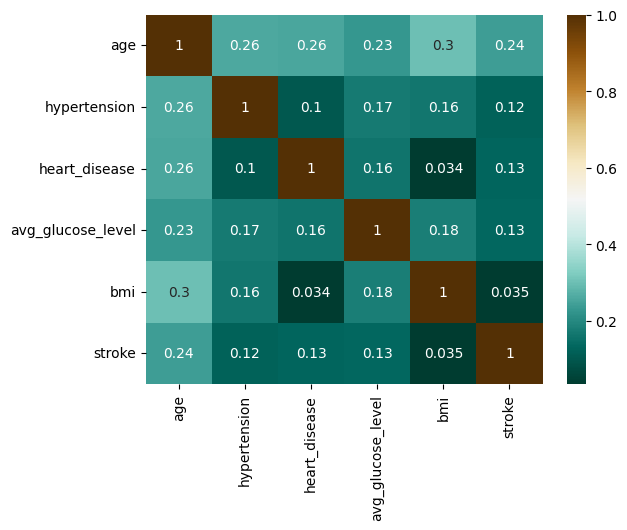

In [227]:
sns.heatmap(data.corr(), cmap = 'BrBG_r',annot=True)

* Age positivly correlates with 'hypertension', 'heart desease',  'avg_glucose_level' and 'bmi'.
* So all of them tends to increase with an increase in age.

<Axes: xlabel='smoking_status', ylabel='count'>

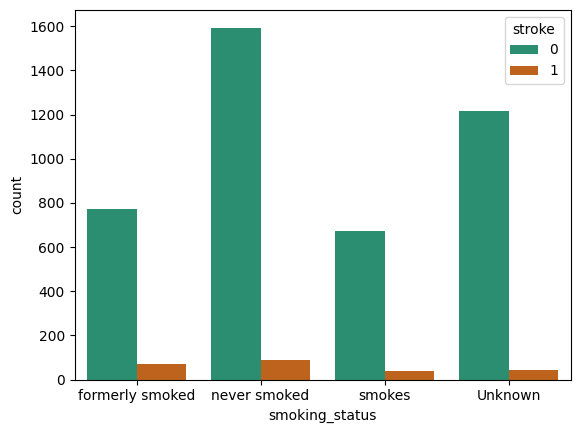

In [228]:
sns.countplot(x= 'smoking_status', data = data, hue='stroke', palette="Dark2")

* To test a model's perfomance I will be using cross validation.
* Before starting work with models, save holdout dataset to evaluate the best models perfomance.
* To make sure train and holdout datasets have same ratio, set parameter stratify.

In [229]:
data, data_holdout = train_test_split(data, test_size=0.15, random_state=0, stratify=data.stroke)

In [230]:
y = data.stroke
features = list(data.columns)[:-1]
data = pd.DataFrame(data[features])

In [231]:
y_holdout = data_holdout.stroke
data_holdout = pd.DataFrame(data_holdout[features])

In [232]:
print(data.shape[0])
print(data_holdout.shape[0])

3825
676


In [233]:
data.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
dtype: object

# Preprocesing

In [234]:
num_pipe = make_pipeline(
    SimpleImputer(strategy="mean", add_indicator=True), StandardScaler(), )
t_lin = [('num', num_pipe, [1, 2, 3, 7, 8]), ('cat', OneHotEncoder(), [0, 4, 5, 6, 9])]
preprocessor_linear = ColumnTransformer(transformers=t_lin)


t_tree = [('num', SimpleImputer(strategy="mean", add_indicator=True), [1, 2, 3, 7, 8]),
          ('cat', OrdinalEncoder(), [0, 4, 5, 6, 9])]
preprocessor_tree = ColumnTransformer(transformers=t_tree)


Choose Balance Accuracy and Recall as a score (might be F2 instead of Recall) not to miss many True Positive predictions

In [235]:
index = []
scores = {"balanced_accuracy": [], 'recall': []}
scoring = ["balanced_accuracy", 'recall']
models = {}

# Basic Models

In [236]:
lr_clf = make_pipeline(preprocessor_linear, LogisticRegression(max_iter=1000))
index += ["Logistic regression"]
cv_result = cross_validate(lr_clf, data, y, scoring=scoring, cv=10)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.505898,0.014286


In [237]:
rf_clf = make_pipeline(
    preprocessor_tree, RandomForestClassifier(random_state=42))
cv_result = cross_validate(rf_clf, data, y, scoring=scoring, cv=10)
index += ["Random forest"]
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.505898,0.014286
Random forest,0.517645,0.038333


Random Forest Perform better than Logistic Regression

In [238]:
svc_cls = make_pipeline(preprocessor_linear, SVC(kernel='linear', C=1))
index += ["C-Support Vector Classification"]
cv_result = cross_validate(svc_cls, data, y, scoring=scoring, cv=10)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.505898,0.014286
Random forest,0.517645,0.038333
C-Support Vector Classification,0.500000,0.000000


The worst perfomance for now

# Use Class [Weight](https://imbalanced-learn.org/stable/auto_examples/applications/plot_impact_imbalanced_classes.html#use-class-weight)

In [239]:
""" class_weight="balanced" such that the weight applied is inversely proportional to the class frequency."""
lr_clf.set_params(logisticregression__class_weight="balanced")

index += ["Logistic regression with balanced class weights"]
models["Logistic regression with balanced class weights"] = lr_clf
cv_result = cross_validate(lr_clf, data, y, scoring=scoring, cv=10)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.505898,0.014286
Random forest,0.517645,0.038333
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.751054,0.771190


In [240]:
rf_clf.set_params(randomforestclassifier__class_weight="balanced")
index += ["Random forest with balanced class weights"]
cv_result = cross_validate(rf_clf, data, y, scoring=scoring, cv=10)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.505898,0.014286
Random forest,0.517645,0.038333
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.751054,0.771190
Random forest with balanced class weights,0.511194,0.024048


Random Forest was not significantly improved like Logistic Regression and SVM

In [241]:
svc_cls.set_params(svc__class_weight='balanced')
index += ["C-Support Vector Classification with balanced class weights"]
models["C-Support Vector Classification with balanced class weights"] = svc_cls
cv_result = cross_validate(svc_cls, data, y, scoring=scoring, cv=10)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.505898,0.014286
Random forest,0.517645,0.038333
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.751054,0.771190
Random forest with balanced class weights,0.511194,0.024048
C-Support Vector Classification with balanced class weights,0.751257,0.780714


**Conclusion:**\
Linear models works with class_weight much better than Random Forest

# Use [Special](https://imbalanced-learn.org/stable/ensemble.html#) Algorithms in Imblearn

In [242]:

bal_rf_clf = make_pipeline(
    preprocessor_tree,
    BalancedRandomForestClassifier(random_state=42, n_jobs=2),)
index += ["Balanced random forest"]
models["Balanced random forest"] = bal_rf_clf
cv_result = cross_validate(bal_rf_clf, data, y, scoring=scoring, cv=10)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.505898,0.014286
Random forest,0.517645,0.038333
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.751054,0.771190
Random forest with balanced class weights,0.511194,0.024048
C-Support Vector Classification with balanced class weights,0.751257,0.780714
Balanced random forest,0.738337,0.771190


In [243]:
rusboost = make_pipeline(
    preprocessor_tree,
    RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',
                              random_state=0))
index += ["Balanced Boosting"]
cv_result = cross_validate(rusboost, data, y, scoring=scoring, cv=10)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores




,balanced_accuracy,recall
Logistic regression,0.505898,0.014286
Random forest,0.517645,0.038333
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.751054,0.771190
Random forest with balanced class weights,0.511194,0.024048
C-Support Vector Classification with balanced class weights,0.751257,0.780714
Balanced random forest,0.738337,0.771190
Balanced Boosting,0.618302,0.427381


# Change Data by adding or deleting some data

## Under Sampling

For all techniques where number of sample changed, doing oversampling BEFORE cross validation would lead to overestimation of the model performance. For this task I, first, split the data into corresponding folds and then proceed to do the upsampling inside the training and validation loop. Also I chose Stratified Kross Validation and each time label will have the same persent of "stroke"

In [244]:
skf = StratifiedKFold(n_splits=10)
for i, (train_index, test_index) in enumerate(skf.split(data, y)):
    y_train = y.iloc[train_index]
    print(y_train.sum() / len(y_train))

0.05461940732132481
0.05461940732132481
0.05461940732132481
0.05461940732132481
0.05461940732132481
0.054893987801336044
0.054603543421434794
0.054603543421434794
0.054603543421434794
0.054603543421434794


In [245]:
def cross_val(model):
  res = {"test_balanced_accuracy": [], "test_recall": []}
  for i, (train_index, test_index) in enumerate(skf.split(data, y)):
    data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(data_train, y_train)
    y_pred = model.predict(data_test)
    res["test_recall"].append(recall_score(y_test, y_pred))
    res["test_balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))

  res["test_recall"] = np.asanyarray(res["test_recall"])
  res["test_balanced_accuracy"] = np.asanyarray(res["test_balanced_accuracy"])

  return res


In [246]:
un_lr_clf = make_pipeline(
    preprocessor_linear,
    RandomUnderSampler(random_state=42),
    LogisticRegression(max_iter=1000),)
index += ["Under-sampling + Logistic regression"]
models["Under-sampling + Logistic regression"] = un_lr_clf
cv_result = cross_val(un_lr_clf)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.505898,0.014286
Random forest,0.517645,0.038333
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.751054,0.771190
Random forest with balanced class weights,0.511194,0.024048
C-Support Vector Classification with balanced class weights,0.751257,0.780714
Balanced random forest,0.738337,0.771190
Balanced Boosting,0.618302,0.427381
Under-sampling + Logistic regression,0.741239,0.771190


In [247]:
rf_clf = make_pipeline(
    preprocessor_tree,
    RandomUnderSampler(random_state=42),
    RandomForestClassifier(random_state=42, n_jobs=2),)
index += ["Under-sampling + Random forest"]
cv_result = cross_val(rf_clf)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.505898,0.014286
Random forest,0.517645,0.038333
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.751054,0.771190
Random forest with balanced class weights,0.511194,0.024048
C-Support Vector Classification with balanced class weights,0.751257,0.780714
Balanced random forest,0.738337,0.771190
Balanced Boosting,0.618302,0.427381
Under-sampling + Logistic regression,0.741239,0.771190
Under-sampling + Random forest,0.732826,0.770952


##Combination of over- and under-sampling

In [248]:
def cross_val_no_pipe(preprocessor, teck, model):

  data = preprocessor.fit_transform(data)

  res = {"test_balanced_accuracy": [], "test_recall": []}
  for i, (train_index, test_index) in enumerate(skf.split(data, y)):
    data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(data_train, y_train)
    y_pred = model.predict(data_test)
    res["test_recall"].append(recall_score(y_test, y_pred))
    res["test_balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))

  res["test_recall"] = np.asanyarray(res["test_recall"])
  res["test_balanced_accuracy"] = np.asanyarray(res["test_balanced_accuracy"])

  return res

In [249]:
enn_lr_clf = make_pipeline(
    preprocessor_linear,
    SMOTEENN(random_state=0),
    LogisticRegression(max_iter=1000),)
index += ["Over-sampling SMOTE and cleaning ENN + Logistic regression"]
models["Over-sampling SMOTE and cleaning ENN + Logistic regression"] = enn_lr_clf
cv_result = cross_val(enn_lr_clf)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())


df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.505898,0.014286
Random forest,0.517645,0.038333
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.751054,0.771190
Random forest with balanced class weights,0.511194,0.024048
C-Support Vector Classification with balanced class weights,0.751257,0.780714
Balanced random forest,0.738337,0.771190
Balanced Boosting,0.618302,0.427381
Under-sampling + Logistic regression,0.741239,0.771190
Under-sampling + Random forest,0.732826,0.770952


In [250]:
enn_rf_clf = make_pipeline(
    preprocessor_tree,
    SMOTEENN(random_state=0),
    RandomForestClassifier(random_state=42),)
index += ["Over-sampling SMOTE and cleaning ENN + Random forest"]
cv_result = cross_val(enn_rf_clf)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.505898,0.014286
Random forest,0.517645,0.038333
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.751054,0.771190
Random forest with balanced class weights,0.511194,0.024048
C-Support Vector Classification with balanced class weights,0.751257,0.780714
Balanced random forest,0.738337,0.771190
Balanced Boosting,0.618302,0.427381
Under-sampling + Logistic regression,0.741239,0.771190
Under-sampling + Random forest,0.732826,0.770952


In [251]:
tomek_lr_clf = make_pipeline(
    preprocessor_linear,
    SMOTETomek(random_state=0),
    LogisticRegression(max_iter=1000),)
index += ["Over-sampling SMOTE and cleaning Tomek links + Logistic regression"]
models["Over-sampling SMOTE and cleaning Tomek links + Logistic regression"] = tomek_lr_clf
cv_result = cross_val(tomek_lr_clf)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.505898,0.014286
Random forest,0.517645,0.038333
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.751054,0.771190
Random forest with balanced class weights,0.511194,0.024048
C-Support Vector Classification with balanced class weights,0.751257,0.780714
Balanced random forest,0.738337,0.771190
Balanced Boosting,0.618302,0.427381
Under-sampling + Logistic regression,0.741239,0.771190
Under-sampling + Random forest,0.732826,0.770952


In [252]:
tomek_rf_clf = make_pipeline(
    preprocessor_tree,
    SMOTETomek(random_state=0),
    RandomForestClassifier(random_state=42, n_jobs=2),)
index += ["Over-sampling SMOTE and cleaning  Tomek links + Random forest"]
cv_result = cross_val(tomek_rf_clf)
scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores['recall'].append(cv_result['test_recall'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.505898,0.014286
Random forest,0.517645,0.038333
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.751054,0.771190
Random forest with balanced class weights,0.511194,0.024048
C-Support Vector Classification with balanced class weights,0.751257,0.780714
Balanced random forest,0.738337,0.771190
Balanced Boosting,0.618302,0.427381
Under-sampling + Logistic regression,0.741239,0.771190
Under-sampling + Random forest,0.732826,0.770952


## All Oversampling Methods

In [253]:
cat_indexes = [data.columns.get_loc(col) for col in data.columns if data[col].dtype == 'object']
all_methods = {"SMOTE": SMOTE(random_state=0, sampling_strategy='minority'),
               "ADASYN": ADASYN(random_state=0),
               'BorderlineSMOTE-1': BorderlineSMOTE(random_state=0, kind="borderline-1"),
               'BorderlineSMOTE-2': BorderlineSMOTE(random_state=0, kind="borderline-2"),
               'SVMSMOTE': SVMSMOTE(random_state=0),
               'RandomOverSampler': RandomOverSampler(random_state=0),}


for key, method in all_methods.items():
    if key in ['RandomOverSampler']:
        model = make_pipeline(preprocessor_tree, method, GradientBoostingClassifier(random_state=0))
        index += [f'Gradient Boosting and {key}']
    else:
        model = make_pipeline(preprocessor_linear, method, LogisticRegression(max_iter=1000))
        index += [f'Logistic Regression and {key}']


    cv_result = cross_val(model)
    scores["balanced_accuracy"].append(cv_result["test_balanced_accuracy"].mean())
    scores['recall'].append(cv_result['test_recall'].mean())
    df_scores = pd.DataFrame(scores, index=index)
df_scores

,balanced_accuracy,recall
Logistic regression,0.505898,0.014286
Random forest,0.517645,0.038333
C-Support Vector Classification,0.500000,0.000000
Logistic regression with balanced class weights,0.751054,0.771190
Random forest with balanced class weights,0.511194,0.024048
C-Support Vector Classification with balanced class weights,0.751257,0.780714
Balanced random forest,0.738337,0.771190
Balanced Boosting,0.618302,0.427381
Under-sampling + Logistic regression,0.741239,0.771190
Under-sampling + Random forest,0.732826,0.770952


In [254]:
lr_border = make_pipeline(preprocessor_linear, BorderlineSMOTE(random_state=0, kind="borderline-2"), LogisticRegression(max_iter=1000, random_state=2))
lr_svm_smote = make_pipeline(preprocessor_linear, SVMSMOTE(random_state=0), LogisticRegression(max_iter=1000, random_state=2)) # gives the best presition
lr_smoteenn = make_pipeline(preprocessor_linear, SMOTEENN(random_state=0), LogisticRegression(max_iter=1000, random_state=2))
lr_smotetomek = make_pipeline(preprocessor_linear, SMOTETomek(random_state=0), LogisticRegression(max_iter=1000, random_state=2))

models['Logistic Regression and BorderlineSMOTE-1'] = lr_border
models['Logistic Regression and SVMSMOTE'] = lr_svm_smote
models['Logistic Regression and SMOTEENN'] = lr_smoteenn
models['Logistic Regression and SMOTETomek'] = lr_smotetomek

# Take a look to the best models

In [256]:
for name, model in models.items():
    print(name)
    model.fit(data, y)
    print(classification_report(y_holdout, model.predict(data_holdout)))
    print('-'*60)

Logistic regression with balanced class weights
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       639
           1       0.17      0.89      0.28        37

    accuracy                           0.75       676
   macro avg       0.58      0.82      0.57       676
weighted avg       0.95      0.75      0.82       676

------------------------------------------------------------
C-Support Vector Classification with balanced class weights
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       639
           1       0.16      0.89      0.27        37

    accuracy                           0.74       676
   macro avg       0.58      0.81      0.56       676
weighted avg       0.95      0.74      0.81       676

------------------------------------------------------------
Balanced random forest
              precision    recall  f1-score   support

           0       0.99      0.72     